In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# Check GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 瑕疵資料讀入及前處理

In [3]:
data_path = "anomaly_datasets/"
x_data_list = []
y_data_list = []
for roots, _, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])
data = pd.DataFrame({'file':x_data_list, 'class':y_data_list})
data.head()

file      class
0   scratches/scratches_38.jpg  scratches
1   scratches/scratches_85.jpg  scratches
2  scratches/scratches_254.jpg  scratches
3  scratches/scratches_236.jpg  scratches
4  scratches/scratches_217.jpg  scratches

Text(0, 0.5, '')

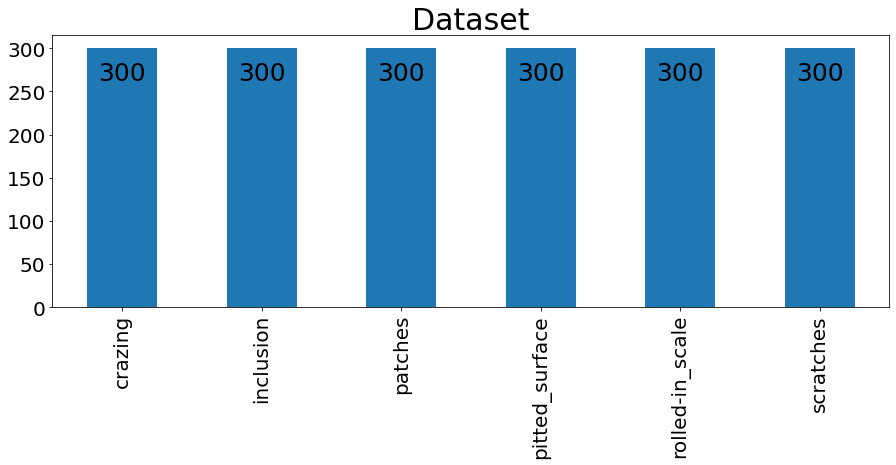

In [4]:
ax = data.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = data.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Dataset", fontsize=30)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

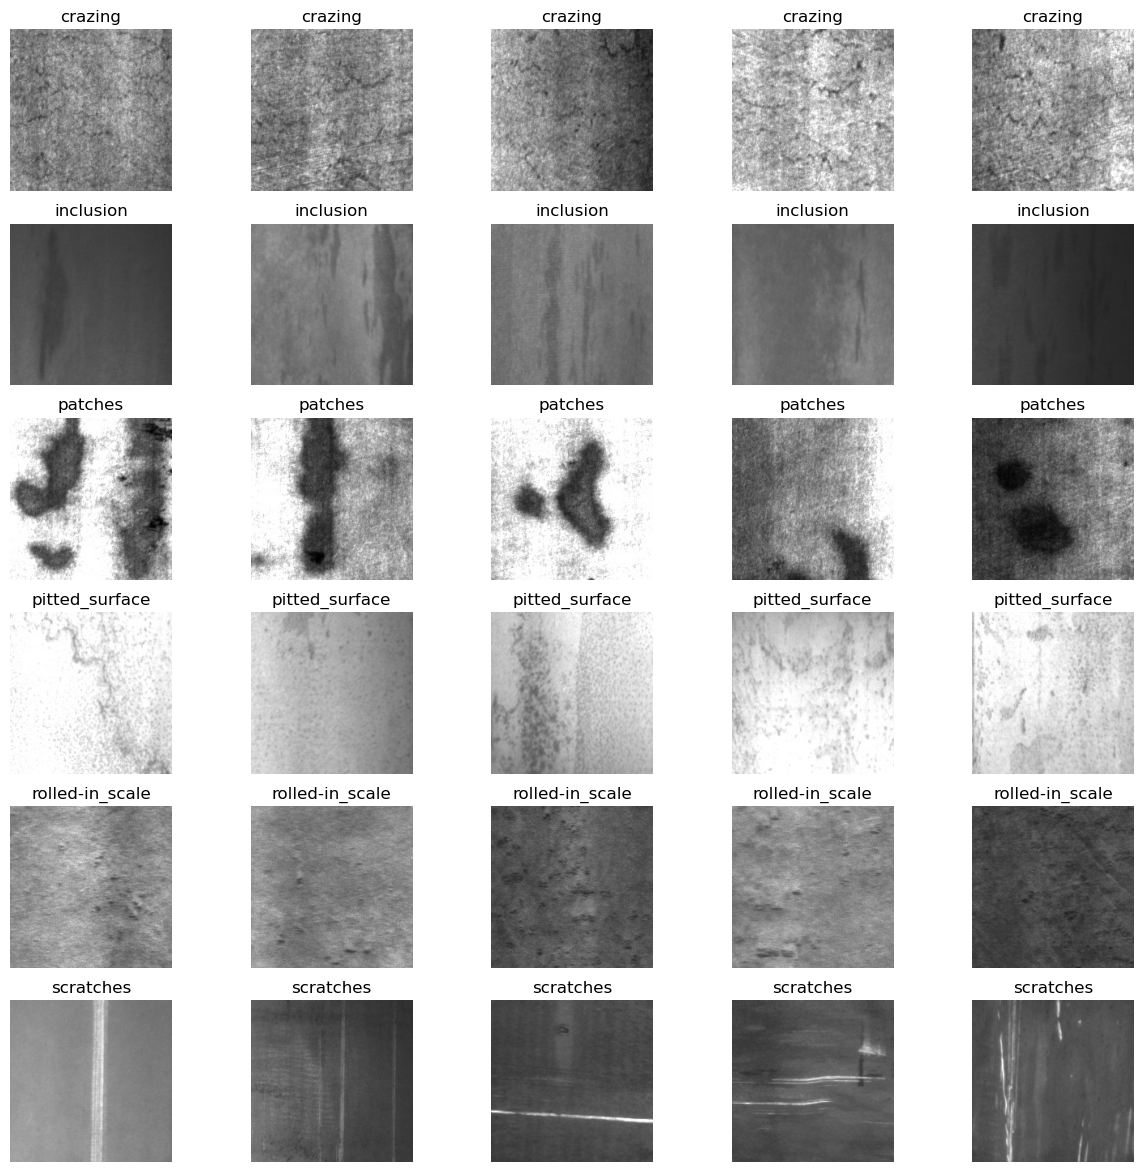

In [5]:
fig = plt.figure(figsize=(15, 15), dpi=100)
i = 1
for label, files in data.groupby('class')['file']:
    for file in files[:5]:
        img = cv2.imread(os.path.join(data_path, file), cv2.IMREAD_COLOR)[:, :, ::-1]
        plt.subplot(6, 5, i)
        plt.title(label)
        plt.imshow(img)
        plt.axis('off')
        i+=1
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

train_list, val_list = train_test_split(data,
                                        test_size=0.2,
                                        random_state=2022,
                                        stratify=data['class'].values)

Text(0, 0.5, '')

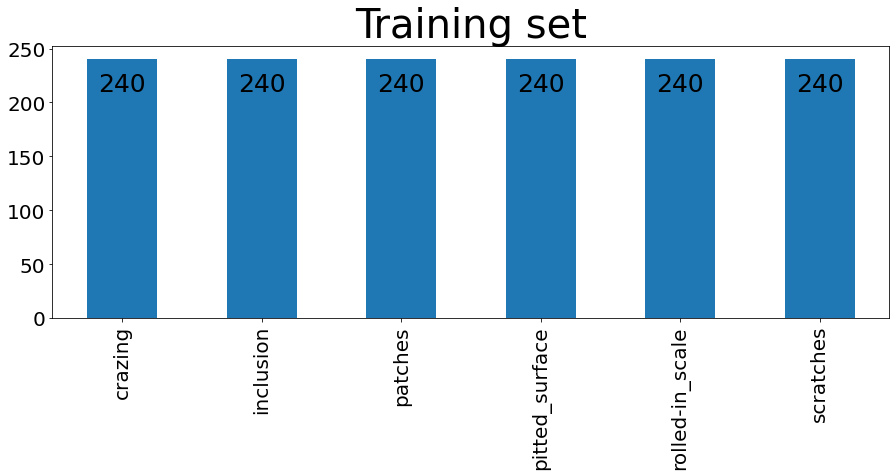

In [10]:
ax = train_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = train_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Training set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

Text(0, 0.5, '')

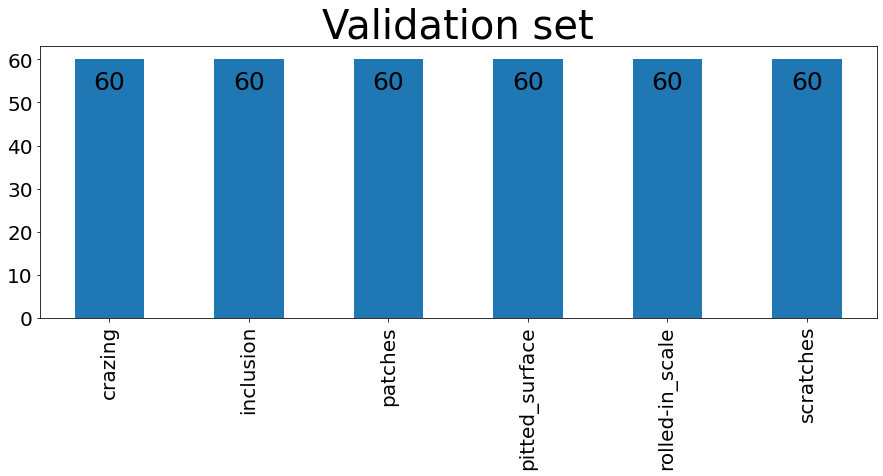

In [11]:
ax = val_list.groupby('class').count().plot(kind='bar', figsize=(15, 5), fontsize=20, legend=False)
grouped_values = val_list.groupby('class').count()['file'].values
for idx, value in enumerate(grouped_values):
    ax.text(idx, value-value//8, value, color="black", ha="center", fontsize=25)
ax.set_title("Validation set", fontsize=40)
ax.set_xlabel("", fontsize=14)
ax.set_ylabel("", fontsize=14)

## 讀入 Pre-trained Model

In [59]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     Flatten, BatchNormalization, Conv2D,
                                     MaxPooling2D, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [60]:
img_size = 224
num_class = len(data['class'].unique())

In [61]:
model_name = 'ResNet50'
base_model = ResNet50(weights='imagenet', include_top=False,
                   input_shape=(img_size, img_size, 3))
x = GlobalAveragePooling2D()(base_model.output)
outputs = Dense(num_class, activation='softmax')(x)
model = Model(inputs=base_model.inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# 決定 Pre-Train 參數量

In [62]:
base_model.trainable = True

# trainable_layer = 10
# for layer in base_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

# Data Augmentation

In [63]:
batch_size = 64
num_steps = len(train_list) // batch_size + 1
num_epochs = 20

In [64]:
train_datagen = ImageDataGenerator(
                                   brightness_range=(0.8, 1.2),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=360,
                                   fill_mode='constant',
                                   cval = 255,
                                   preprocessing_function=preprocess_input
                                  )
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [65]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="file",
                                                    y_col="class",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

val_generator = datagen.flow_from_dataframe(dataframe=val_list,
                                            directory=data_path,
                                            x_col="file",
                                            y_col="class",
                                            target_size=img_shape,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

Found 1440 validated image filenames belonging to 6 classes.
Found 360 validated image filenames belonging to 6 classes.


## 開始訓練模型

In [66]:
def callbacks_fun(model_name, img_size):
    model_dir = f'model-logs/{model_name}'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    logfiles = model_dir + '/basic_model'
    modelfiles = model_dir + f'/{model_name}_{img_size}.h5'
    model_cbk = TensorBoard(log_dir=logfiles, histogram_freq=1)
    model_mckp = ModelCheckpoint(modelfiles,
                                 monitor='val_accuracy',
                                 save_best_only=True)  
    LR_decay = ReduceLROnPlateau(monitor='val_loss',
                                 patience=3,
                                 verbose=1,
                                 factor=0.8)

    return [model_cbk, model_mckp, LR_decay]

In [67]:
# 設定 cllbacks
callbacks_list = callbacks_fun(model_name, img_size)

In [68]:
history = model.fit(train_generator,
                    steps_per_epoch=num_steps,
                    epochs=num_epochs,
                    validation_data=val_generator,
                    callbacks=callbacks_list)

Epoch 1/20


2022-05-04 14:44:52.024943: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-04 14:44:52.037839: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-04 14:44:52.055771: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-04 14:44:52.063336: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

23/23 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8917

2022-05-04 14:45:08.565662: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


23/23 [==============================] - 26s 891ms/step - loss: 0.3517 - accuracy: 0.8917 - val_loss: 1040.8073 - val_accuracy: 0.4917 - lr: 5.0000e-04
Epoch 2/20
23/23 [==============================] - 19s 799ms/step - loss: 0.1454 - accuracy: 0.9569 - val_loss: 74.2704 - val_accuracy: 0.3611 - lr: 5.0000e-04
Epoch 3/20
23/23 [==============================] - 18s 794ms/step - loss: 0.1153 - accuracy: 0.9736 - val_loss: 103.0510 - val_accuracy: 0.3389 - lr: 5.0000e-04
Epoch 4/20
23/23 [==============================] - 20s 848ms/step - loss: 0.0514 - accuracy: 0.9847 - val_loss: 5.3476 - val_accuracy: 0.7861 - lr: 5.0000e-04
Epoch 5/20
23/23 [==============================] - 20s 855ms/step - loss: 0.0192 - accuracy: 0.9944 - val_loss: 3.9593 - val_accuracy: 0.8333 - lr: 5.0000e-04
Epoch 6/20
23/23 [==============================] - 22s 959ms/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.4998 - val_accuracy: 0.9278 - lr: 5.0000e-04
Epoch 7/20
23/23 [===========================

## 訓練結果視覺化

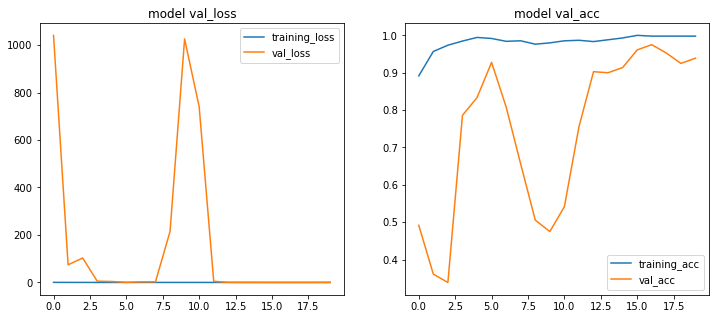

In [69]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model '+eachy)
plt.show()

In [70]:
model = load_model(f'./model-logs/{model_name}/{model_name}_{img_size}.h5')

In [71]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
y_pred = model.predict(val_generator).argmax(-1)
y_val = val_generator.classes

In [72]:
val_generator.class_indices.keys()

dict_keys(['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'])

ResNet50 Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.87      1.00      0.93        60
           2       1.00      1.00      1.00        60
           3       1.00      0.85      0.92        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60

    accuracy                           0.97       360
   macro avg       0.98      0.97      0.97       360
weighted avg       0.98      0.97      0.97       360



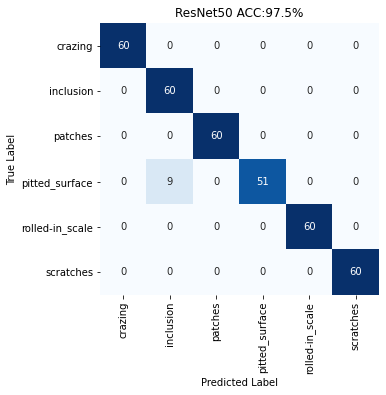

In [73]:
print(f"{model_name} Report: \n", classification_report(y_val, y_pred))
ACC = accuracy_score(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
                          xticklabels=val_generator.class_indices.keys(),
                          yticklabels=val_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'{model_name} ACC:{ACC*100:.4}%')
plt.show()

## 顯示預測錯誤的影像

In [74]:
err_idx = np.where(y_val!=y_pred)[0]
n = len(err_idx)

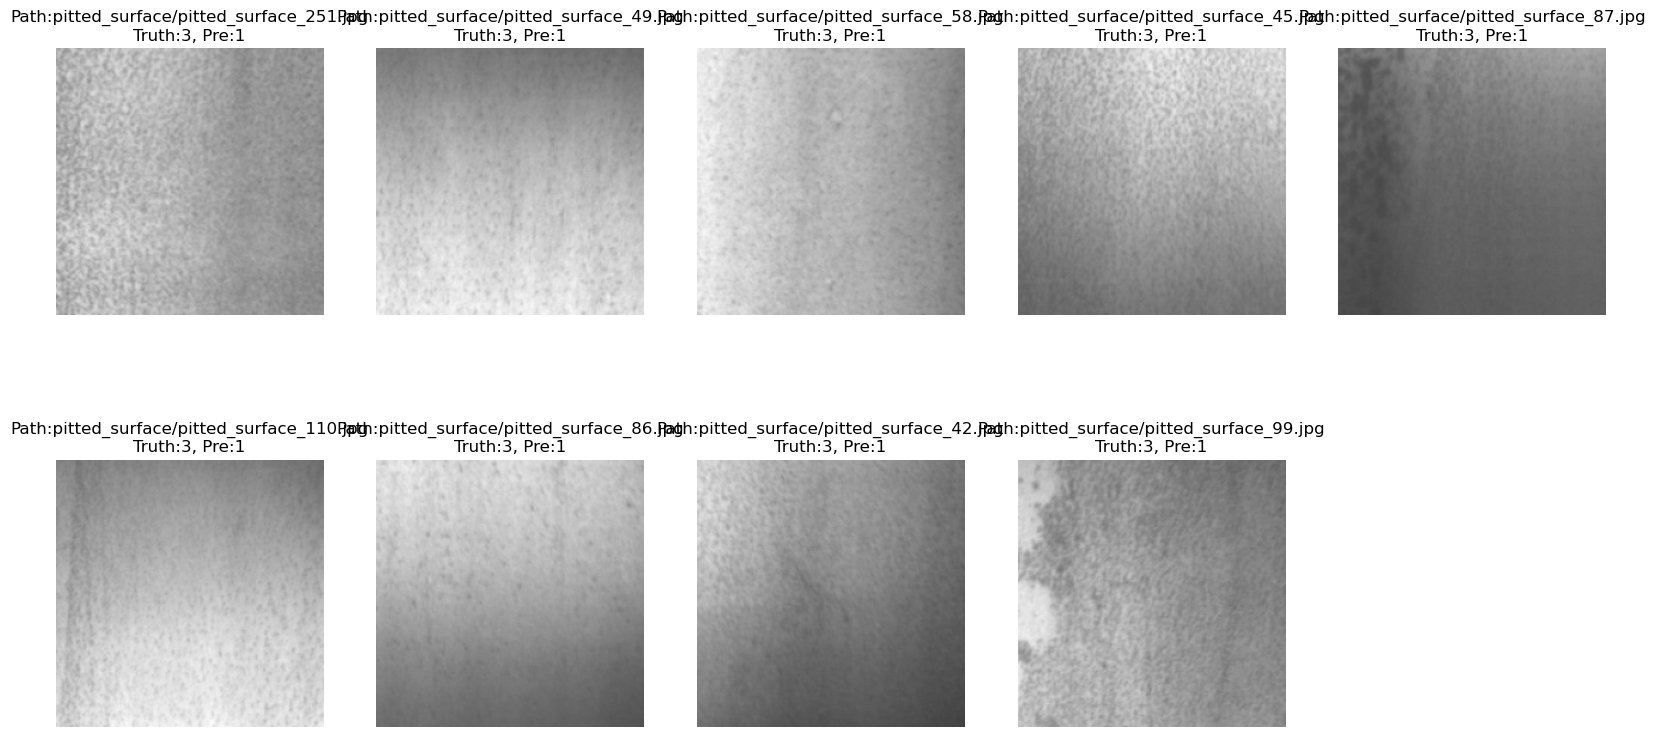

In [75]:
# show image
fig = plt.figure(figsize=(20, 10), dpi=100)
for i, idx in enumerate(err_idx):
    img = cv2.imread(os.path.join(data_path, val_list['file'].values[idx]), cv2.IMREAD_COLOR)[:, :, ::-1]
    img = cv2.resize(img, (img_size, img_size))
    plt.subplot(math.ceil(n/5), 5, i+1)
    plt.title('Path:'+val_list['file'].values[idx]+'\nTruth:'+str(y_val[idx])+', Pre:'+str(y_pred[idx]))
    plt.imshow(img)
    plt.axis('off')
plt.show()

## [1. Grad-CAM (Ancona et al. 16)](https://arxiv.org/abs/1610.02391)

In [76]:
import matplotlib.cm as cm

In [77]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [78]:
def infer_target_layer(model):

    for layer in reversed(model.layers):
        # Select closest 4D layer to the end of the network.
        if len(layer.output_shape) == 4:
            return layer.name

    raise ValueError(
        "Model does not seem to contain 4D layer. CAM-Based method cannot be applied."
    )

In [79]:
def gradcam(image,
            model,
            layer_name=None,
            target_class_idx=None):
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    if layer_name is None:
        layer_name = infer_target_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(inputs)
        if target_class_idx is None:
            target_class_idx = tf.argmax(preds[0])
        class_channel = preds[:, target_class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap, target_class_idx.numpy()

In [80]:
def display_gradcam(image, label, heatmap, target_class_idx, method='Grad CAM'):
    heatmap_3dim = tf.expand_dims(heatmap, axis=2)
    attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                            subplot_kw={'xticks':[], 'yticks':[]})

    axs[0, 0].set_title('Pred: '+list(train_generator.class_indices.keys())[target_class_idx]+
                        '\nGT: '+list(train_generator.class_indices.keys())[label],
                        fontsize=20)
    axs[0, 0].imshow(image/255)

    axs[0, 1].set_title(method, fontsize=20)
    axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[0, 2].set_title('Overlay', fontsize=20)
    axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[0, 2].imshow(image/255, alpha=0.4)

In [81]:
def get_data(val_generator):
    data_img = []
    data_label = []
    i = 0
    for img, label in val_generator:
        for j in range(len(img)):
            if label[j].argmax(-1)==i:
                data_img.append(img[j]+(103.9, 116.7, 123.6))
                data_label.append(label[j].argmax(-1))
                i+=1
                if i>=len(label[j]):
                    return data_img, data_label

In [90]:
data_img, data_label = get_data(val_generator)

In [91]:
val_generator.class_indices

{'crazing': 0,
 'inclusion': 1,
 'patches': 2,
 'pitted_surface': 3,
 'rolled-in_scale': 4,
 'scratches': 5}

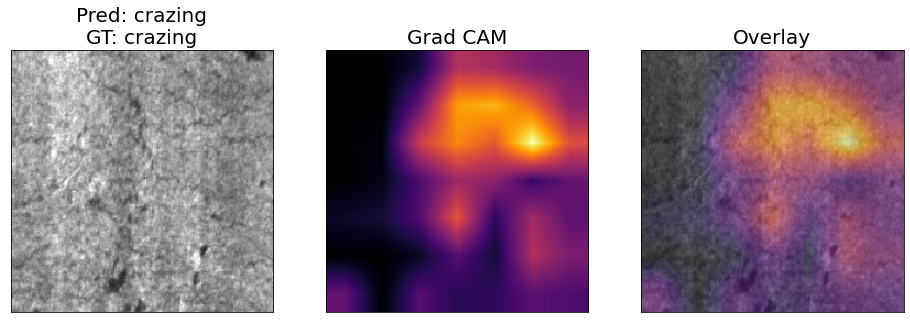

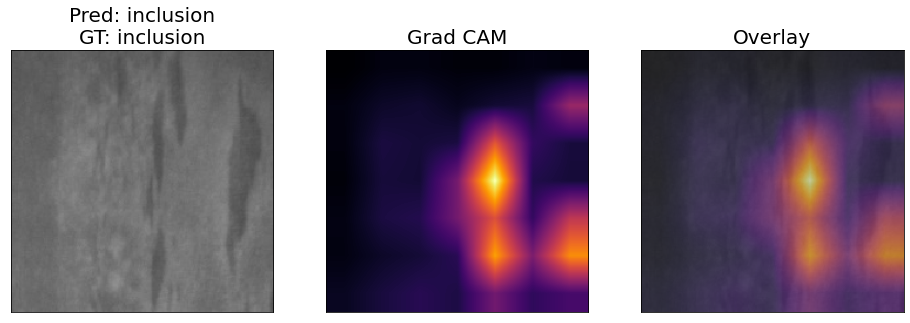

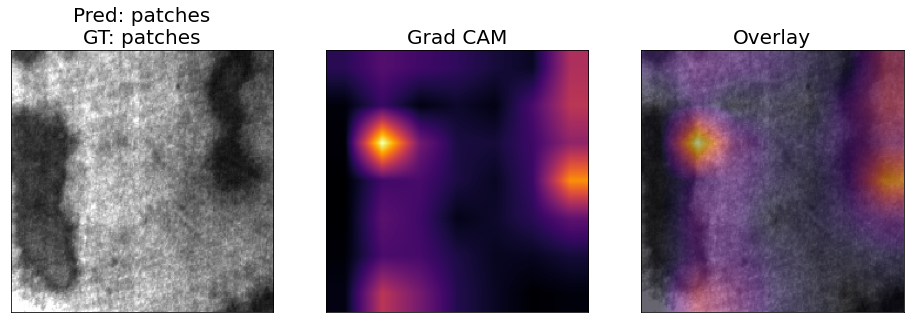

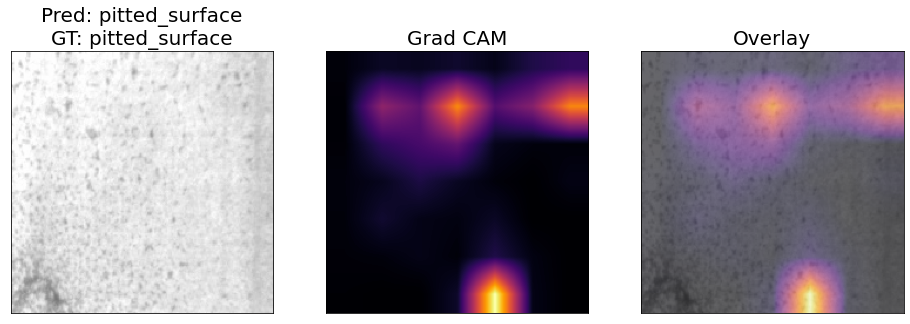

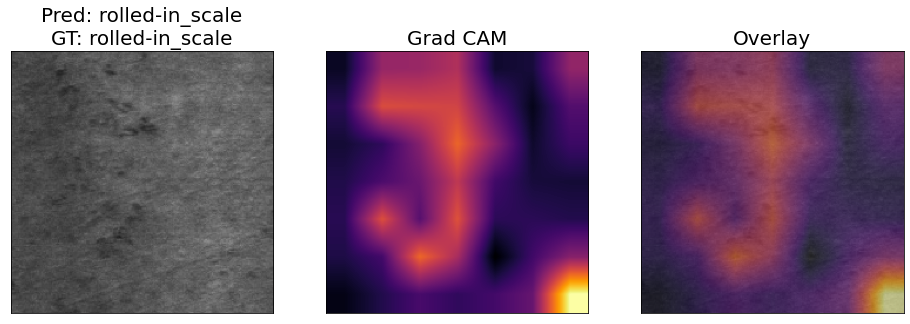

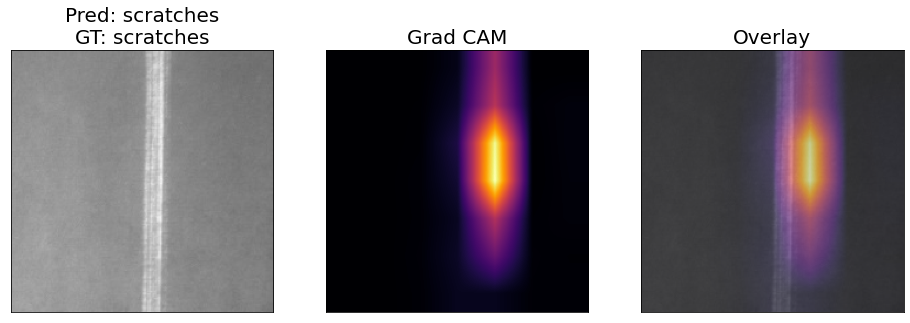

In [92]:
for image, label in zip(data_img, data_label):
    heatmap, target_class_idx = gradcam(image, model)
    display_gradcam(image, label, heatmap, target_class_idx)

## [2. Layer-CAM (Peng-Tao et al. 21)](http://mftp.mmcheng.net/Papers/21TIP_LayerCAM.pdf)

In [93]:
layer_names = ['conv5_block3_out', 'conv4_block6_out', 'conv3_block4_out']

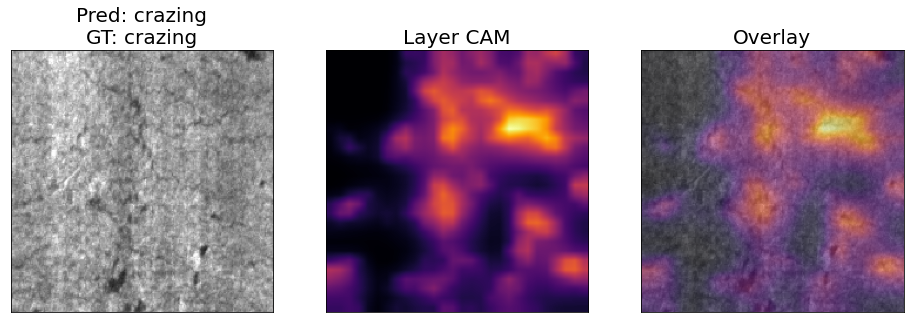

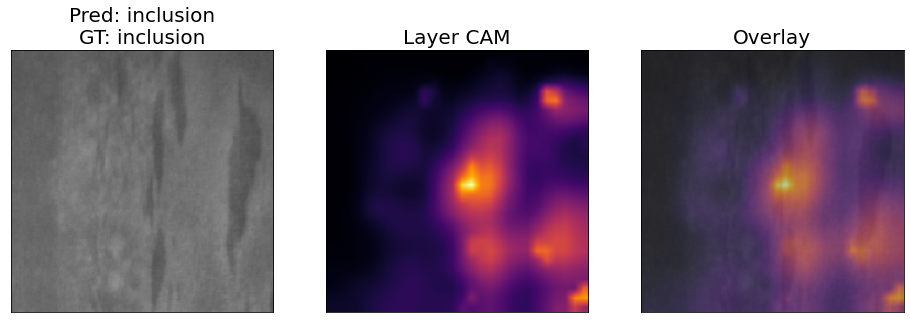

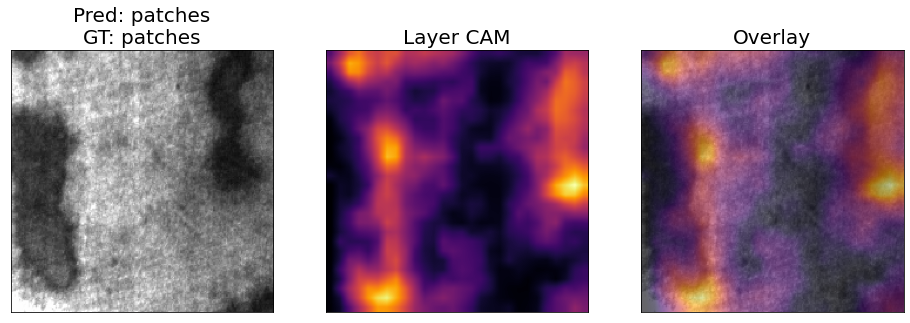

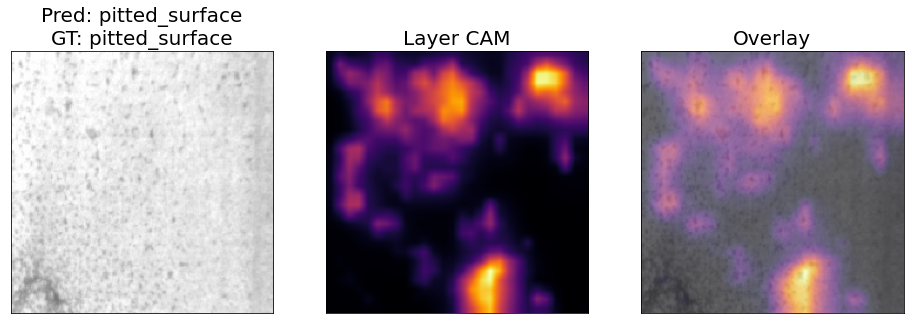

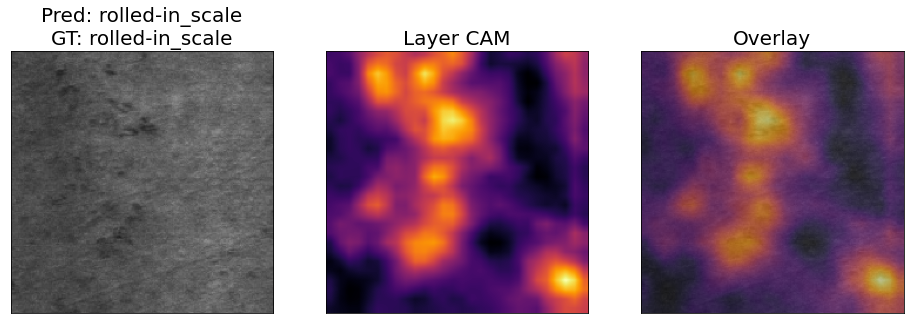

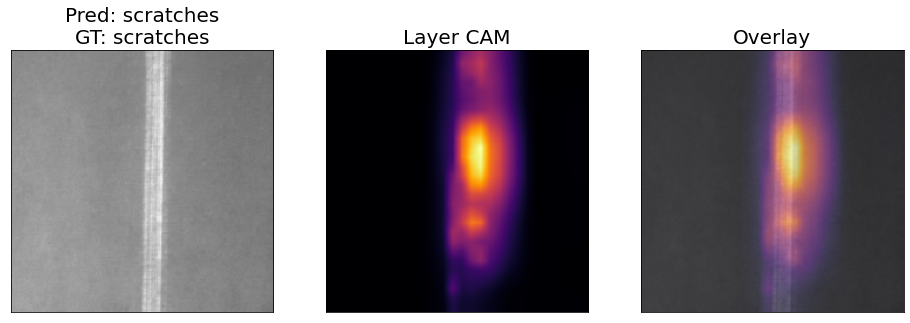

In [94]:
# Generate class activation heatmap
for image, label in zip(data_img, data_label):
    heatmaps = []
    for layer_name in layer_names:
        heatmap, target_class_idx = gradcam(image, model, layer_name)
        heatmaps.append(heatmap)
    hm_out = np.zeros((28, 28))
    for hm in heatmaps:
        hm_out += cv2.resize(hm.numpy(), (28, 28))
    hm_out /= tf.math.reduce_max(hm_out)
    display_gradcam(image, label, hm_out, target_class_idx, 'Layer CAM')